# Hyper-parameter tuning and cross-validation

In this notebook, we will look at how to tune hyper-parameters using cross-validation. 

We will, again, use the diabetes dataset that can be used to classify whether people have diabetes.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

In [2]:
diab_data = pd.read_csv('diabetes.csv')

In [3]:
diab_data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
y = diab_data["Outcome"]
X = diab_data.drop(columns = ["Age", "Outcome"])

For the K-Nearest-Neighbor classifier, we actually get very different results dependent on the train-test split (based on what number we used for `random_state`). Let us first visualize that by training 50 different KNN models with $K=5$ for different train-test splits:

In [5]:
acclist = [] 

random_seeds = np.random.randint(1000, size=50)
for seed in random_seeds:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)
    knn5 = KNeighborsClassifier(n_neighbors=5)
    knn5.fit(X_train, y_train)
    y_pred5_test = knn5.predict(X_test)
    acclist.append({"seed": seed, "Test accuracy": accuracy_score(y_test, y_pred5_test)})

accuracyDF = pd.DataFrame(acclist)
accuracyDF["Test accuracy"].describe()

count    50.000000
mean      0.702292
std       0.028805
min       0.635417
25%       0.683594
50%       0.700521
75%       0.722656
max       0.770833
Name: Test accuracy, dtype: float64

We can plot a histogram of the different test accuracies we get:

[]

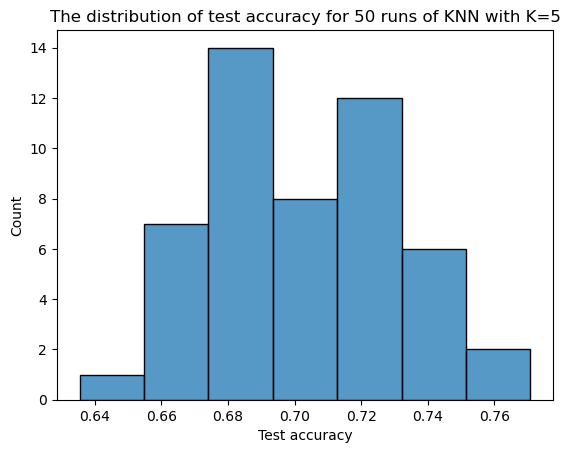

In [6]:
sns.histplot(data = accuracyDF, x = "Test accuracy")
plt.title("The distribution of test accuracy for 50 runs of KNN with K=5")
plt.plot()

We can actually also run our k-sweep loop from last time with different train-test split to see if we get different best K.

In [7]:
best_ks = []

random_seeds = np.random.randint(1000, size=50)
for seed in random_seeds:

    # Random train-test split with 25% data for testing
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)

    accuracy_row_list = [] 
    
    for k in range(2, 30):
        # Model intializing
        knn = KNeighborsClassifier(n_neighbors=k)

        # Training (very light compared to an eager learner)
        knn.fit(X_train, y_train)

        # Predicting on train and test set
        y_pred_train = knn.predict(X_train)
        y_pred_test = knn.predict(X_test)

        # Get test accuracy and adding to list
        accuracy_test = accuracy_score(y_test, y_pred_test)
        accuracy_row_list.append({"k": k, "Test accuracy": accuracy_test})

    # Appending the best K for the current seed to the best_ks list.
    best_k_row = pd.DataFrame(accuracy_row_list).sort_values("Test accuracy",  ascending=False)
    best_ks.append({"Seed": seed, "Best K": best_k_row.iloc[0]["k"].astype(int), "Test accuracy": best_k_row.iloc[0]["Test accuracy"]})

# Making the best_ks list into a data frame.        
bestKs = pd.DataFrame(best_ks)

In [8]:
bestKs.head()

,Seed,Best K,Test accuracy
0,461,22,0.755208
1,811,17,0.802083
2,881,27,0.770833
3,89,25,0.744792
4,672,7,0.755208


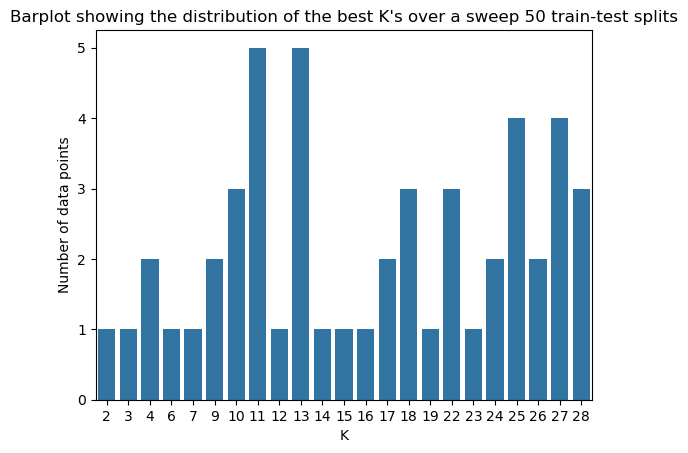

In [9]:
sns.countplot(x = "Best K", data = bestKs)
plt.title("Barplot showing the distribution of the best K's over a sweep 50 train-test splits")
plt.xlabel("K")
plt.ylabel("Number of data points")
plt.show()

We only allowed K to be below 30 here, but we clearly see a lot of different best K here! If you run the code again, you will get a different result, so it is highly unstable, the choice of K.

## Cross-validation

Let us try to use cross-validation instead. There are multiple ways of doing this, but one is to use the `cross_val_score` from Scikit-learn model_selection module. It makes k-fold cross validation - that is, it trains k different models and evaluate the accuracy on the k hold-out folds. Note that, it only returns the accuracy scores of each fold. We should then train the model afterward on the entire set. (Strictly speaking, we should have done a train test split first and only ran the cross-validation on this training set. Then trained the model on the entire training set, and then finally evaluated the model on the untouched test set.)

In [10]:
from sklearn.model_selection import cross_val_score

knn5 = KNeighborsClassifier(n_neighbors=5)
scores = cross_val_score(knn5, X, y, cv = 5)  # cv = 5 means 5-fold cross validation
scores

array([0.70779221, 0.66233766, 0.70779221, 0.75816993, 0.67973856])

We can then use the mean of these as an unbiased estimate of the accuracy of our model on future unseen data:

In [11]:
scores.mean()

np.float64(0.7031661149308208)

Let us try out with different K's to see how much variance we have in this estimate:

In [12]:
kacclist = [] 
for k in range(2, 20):
    scores = cross_val_score(knn5, X, y, cv = k)
    kacclist.append({"Folds": k, "Mean accuracy": scores.mean()})

kaccuracyDF = pd.DataFrame(kacclist)
kaccuracyDF["Mean accuracy"].describe()

count    18.000000
mean      0.706617
std       0.004688
min       0.697917
25%       0.703512
50%       0.705852
75%       0.708414
max       0.718750
Name: Mean accuracy, dtype: float64

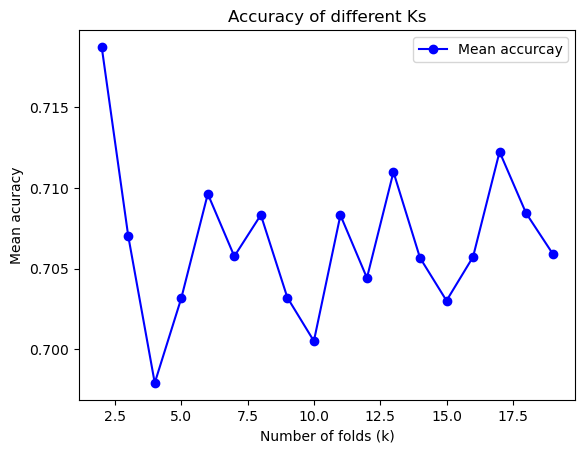

In [13]:
plt.plot(kaccuracyDF["Folds"], kaccuracyDF["Mean accuracy"], label = "Mean accurcay", color='blue', marker='o', linestyle='solid')    
plt.xlabel('Number of folds (k)')
plt.ylabel('Mean acuracy')
plt.title("Accuracy of different Ks")
plt.legend()

plt.show()

[]

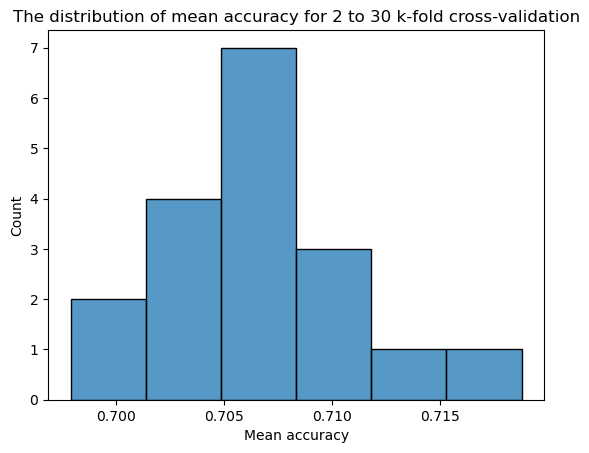

In [14]:
sns.histplot(data = kaccuracyDF, x = "Mean accuracy")
plt.title("The distribution of mean accuracy for 2 to 30 k-fold cross-validation")
plt.plot()

We can now use 5-fold cross validation to chose a $K$ for the KNN classifier:

In [15]:
def knnSweepCrossValidation(X, y, maxK, folds=5):
    kacclist = []
    
    for k in range(2, maxK):
        knn = KNeighborsClassifier(n_neighbors=k)     
        scores = cross_val_score(knn, X, y, cv = folds)
        kacclist.append({"K": k, "CV accuracy": scores.mean()})

    return pd.DataFrame(kacclist)

In [16]:
knnSweepCrossValidation(X, y, 30)

,K,CV accuracy
0,2,0.703149
1,3,0.695357
2,4,0.713547
3,5,0.703166
4,6,0.705747
5,7,0.716128
6,8,0.734386
7,9,0.725261
8,10,0.744801
9,11,0.734377


Let us compare it to the `random_state=42` from last time.

In [17]:
def knnSweep(X, y, maxK):
    accuracy_row_list = []
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
    for k in range(2, maxK):
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        y_pred_test = knn.predict(X_test)
        accuracy_test = accuracy_score(y_test, y_pred_test)
        accuracy_row_list.append({"K": k, "Random42 test accuracy": accuracy_test})

    return pd.DataFrame(accuracy_row_list)

In [18]:
ran30 = knnSweep(X, y, 30)
cv30 = knnSweepCrossValidation(X, y, 30)

compareDF = pd.merge(ran30, cv30, on="K")
compareDF.head()

,K,Random42 test accuracy,CV accuracy
0,2,0.713542,0.703149
1,3,0.635417,0.695357
2,4,0.708333,0.713547
3,5,0.682292,0.703166
4,6,0.666667,0.705747


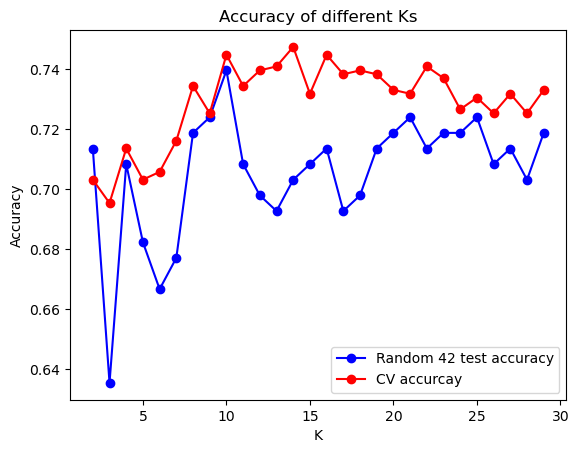

In [19]:
plt.plot(compareDF["K"], compareDF["Random42 test accuracy"], label = 'Random 42 test accuracy', color='blue', marker='o', linestyle='solid')
plt.plot(compareDF["K"], compareDF["CV accuracy"], label = 'CV accurcay', color='red', marker='o', linestyle='solid')
    
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.title("Accuracy of different Ks")
plt.legend()

plt.show()

We clearly see much less variance in the cross-validation accuracy! There is still variation, but that is mainly due to the fact that we have a small dataset and KNN is a model type with high variance. But it looks like that $K=10$ is a sensible choice.